# IoT no uniforme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from pathlib import Path

## Auxilliar functions

In [2]:
###
class AccessLog:
    """ All operation in AccessLog (AL) """
    def __init__(self, df_users, df_rscs, df_env, df_op) -> None:
        """ Initialize AL attributes """
        self.df_users = df_users
        self.df_rscs = df_rscs
        self.df_env = df_env
        self.df_op = df_op
        self.user_attrs = df_users.columns
        self.rsrc_attrs = df_rscs.columns
        self.universal_access_log = []
    
    def compute_universal_al(self) -> None:
        """ Compute the universal Access Log (UAL). |UAL| = |U| x |R|"""
        access_log = []
        for user in self.df_users.values:
            for res in self.df_rscs.values:
                for env in self.df_env.values:   
                    for op in self.df_op.values:
                        access_log.append(list(user) + list(res)+ list(env) + list(op))
        
        access_log = pd.DataFrame(access_log)
        access_log.columns = list(self.df_users.columns) + list(self.df_rscs.columns) + list(self.df_env.columns) + list(self.df_op.columns)
        self.universal_access_log = access_log

    def tuple_rule_evaluation(self, item_rule, acc_req):
        if item_rule[0] == 0:
            if acc_req[item_rule[1]] != item_rule[2]:
                return False                
        if item_rule[0] == 1: # => attr1.val = attr2.val
            if acc_req[item_rule[1]] != acc_req[item_rule[2]]:
                return False
        if item_rule[0] == 2: # => attr in values.list
            if not acc_req[item_rule[1]] in item_rule[2]:
                return False
        if item_rule[0] == 3: # => attr < values.list
            if not acc_req[item_rule[1]] > item_rule[2]:
                return False
        if item_rule[0] == 4: # => attr != values.list
            if not acc_req[item_rule[1]] == item_rule[2]:
                return False
        return True

    def policy_evaluation(self, policy) -> None:
        """ Compare each access record with a policy set."""
        false_negs = [] # False negatives
        true_pos = [] # True positives
        len_policy = len(policy)
        counter = 0

        for acc_req in self.universal_access_log.iloc:
            denies_count = 0
            for rule in policy:
                res = True
                for item_rule in rule:
                    res = self.tuple_rule_evaluation(item_rule, acc_req)                    
                if res == False:
                    denies_count += 1
            if denies_count == len_policy:
                false_negs.append(acc_req)
            else:
                true_pos.append(acc_req)

            counter += 1
            if counter % 500000 == 0:
                print("Counter:", counter)
        
        false_negs = pd.DataFrame(false_negs)
        true_pos = pd.DataFrame(true_pos)

        print("FN;", len(false_negs), "\t\tTP:", len(true_pos))

        # Add "ACTION" column
        false_negs["ACTION"] = 0
        true_pos["ACTION"] = 1

        # Access log with "ACTION" column
        self.universal_access_log = pd.concat([true_pos,false_negs])

    def get_sparse_al(self, fraction, random_state=None, previous_al=None):        
        """ Compute the sparse access log (SAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al
        sparse_positive_al = None   
        pos_access_req = acc_log[acc_log["ACTION"]==1]
        if random_state != None:
            sparse_positive_al = pos_access_req.sample(frac=fraction,
                                                       random_state=random_state)
        else:
            sparse_positive_al = pos_access_req.sample(frac=fraction)

        return pd.concat([sparse_positive_al, acc_log[acc_log["ACTION"]==0]])

    def get_noisy_al(self, fraction, random_state=None, previous_al=None):
        """ Compute the noisy access log (NAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al

        noysi_al = None
        if random_state != None:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction,
                                                      random_state = random_state)
        else:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction)
        
        noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                        
        noisy_acc_req = None
        normal_acc_req = None
        for noisy_idx, normal_idx, in noisy_acc_log_selection:
            noisy_acc_req = acc_log.iloc[noisy_idx]
            normal_acc_req = acc_log.iloc[normal_idx]

        # Change the resolution in the noisy_selection dataset
        noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)

        noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

        return noysi_al

    def get_balanced_al(self, positive_frac, random_state = None, previous_al = None):
        acc_log = self.universal_access_log
        
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al        

        # Compute the original balanced
        pos_acc_log = acc_log[acc_log["ACTION"]==1]
        neg_acc_log = acc_log[acc_log["ACTION"]==0]

        len_al = len(acc_log)
        len_pos_ar = len(pos_acc_log)

        limit_positive_frac = ( len_pos_ar * 100 ) / len_al

        if positive_frac < limit_positive_frac and positive_frac > 1:
            print("Is not possible")
            return
        
        len_neg_ar = int(( (1-positive_frac) * 100 * len_pos_ar ) / (positive_frac*100))        

        neg_acc_req = []
        if random_state != None:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar,
                                             random_state=random_state)
        else:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar)

        return pd.concat([pos_acc_log, neg_acc_req])

### Get probability distribution

def get_probability_distribution(n, sample_size, probability_parameters, type="normal",):
    """ Get the probability distribution for n elementsin sample size."""
    count = None

    if type=="normal":
        distri = np.random.normal(probability_parameters["mu"], 
                                  probability_parameters["sigma"], 
                                  size=sample_size)
        count, _, _ = plt.hist(distri, n)

    if type=="pareto":        
        distri = (np.random.pareto(probability_parameters["alpha"], sample_size) + 1) * probability_parameters["mu"]
        count, _, _ = plt.hist(distri, n)

    if type==None:
        return None       


    return count/sample_size

def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """ Sampling a dataframe based on a given distribution. """
    new_sample = pd.DataFrame() # Store all access requests
    for i in prob_distri.iloc:
        temp = access_log[access_log[class_name]==i[0]]
        n_samples = int(i[1]*sample_size)        
        temp = temp.sample(n=n_samples, replace=True)
        new_sample = pd.concat([new_sample, temp])

    return new_sample

## Main

In [4]:
### Load an access log
file_path = "IOT-complete-AL.csv"
acc_log = pd.read_csv(file_path)
acc_log = acc_log[acc_log.columns[1:]]

print("### *** Access Log loaded *** ###")
print(acc_log.info())

### *** Access Log loaded *** ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5702400 entries, 0 to 5702399
Data columns (total 13 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   role         object
 1   age          int64 
 2   health       object
 3   uname        int64 
 4   type         object
 5   area         object
 6   mode         object
 7   temperature  int64 
 8   lockstatus   object
 9   rname        int64 
 10  location     object
 11  timeday      object
 12  op           object
dtypes: int64(4), object(9)
memory usage: 565.6+ MB
None


### User distribution

In [5]:
### Get all users
users = acc_log.uname.unique()
print("# users:", len(users), "\t Head ->", users[:5], "\t tail -> ", users[-5:])

# users: 120 	 Head -> [0 1 2 3 4] 	 tail ->  [118 119 120 121 122]


#### Normal

Done!


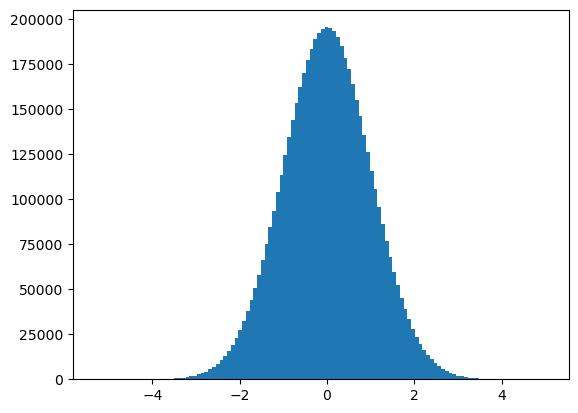

In [6]:
proba_param = {"mu": 0, "sigma": 1}
prob = get_probability_distribution(len(users), len(acc_log), proba_param, "normal")
df_user_prob = pd.DataFrame({"UID": users, "prob": prob})
print("Done!")

Sum p(x) = 1.0


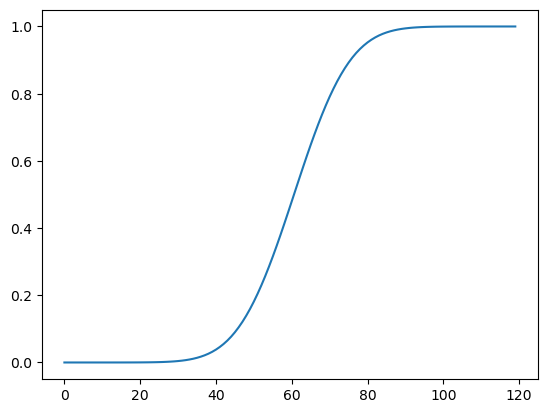

In [7]:
### Check CDF
print("Sum p(x) =", df_user_prob.prob.sum())
cdf = np.cumsum(df_user_prob.prob)
plt.plot(range(len(cdf)), cdf)

In [8]:
### Get sample distribution
normal_acc_log = get_sample_by_distribution(acc_log, len(acc_log), df_user_prob, "uname")
print("*** Done! ***")
print(normal_acc_log.info())

*** Done! ***
<class 'pandas.core.frame.DataFrame'>
Index: 5702395 entries, 40970 to 5699795
Data columns (total 13 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   role         object
 1   age          int64 
 2   health       object
 3   uname        int64 
 4   type         object
 5   area         object
 6   mode         object
 7   temperature  int64 
 8   lockstatus   object
 9   rname        int64 
 10  location     object
 11  timeday      object
 12  op           object
dtypes: int64(4), object(9)
memory usage: 609.1+ MB
None


In [9]:
print("|L-original| únicos: ", len(acc_log.drop_duplicates()))
print("|L-normal| únicos: ", len(normal_acc_log.drop_duplicates()))
print("Diferencia = ", len(acc_log.drop_duplicates()) - len(normal_acc_log.drop_duplicates()))
print()

### new data information
print("Size of Original Access Log = ", len(acc_log))
print("Size of normal Access Log = ", len(normal_acc_log),"\n")

new_prob_distri = normal_acc_log.uname.value_counts(normalize=True)
print("# users in Original Access Log =", len(users))
print("# users in normal Access Log =", len(new_prob_distri))
print("Difference =", len(users) - len(new_prob_distri))

|L-original| únicos:  5702400
|L-normal| únicos:  2082423
Diferencia =  3619977

Size of Original Access Log =  5702400
Size of normal Access Log =  5702395 

# users in Original Access Log = 120
# users in normal Access Log = 119
Difference = 1


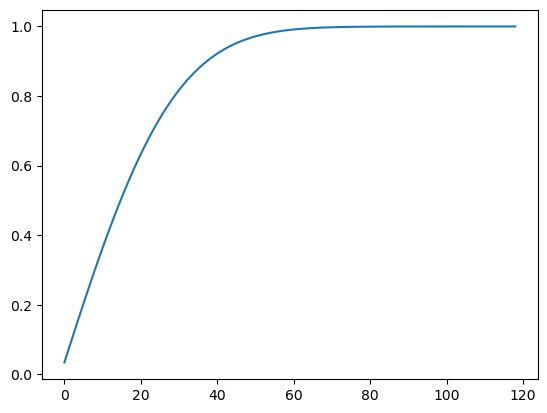

In [10]:
cdf = np.cumsum(sorted(new_prob_distri, reverse=True))
plt.plot(range(len(cdf)), cdf)

## Analisis

([<matplotlib.patches.Wedge at 0x7f440360fb10>,
 [Text(0.5214320689490651, 0.9685600639462157, 'anormal'),
  Text(-1.095639877802395, -0.09784302820923528, 'normal'),
  Text(0.6054567372527037, -0.9183801714515132, 'emergency'),
  Text(1.099999997639111, -7.206910591644111e-05, 'health')],
 [Text(0.2844174921540355, 0.5283054894252085, '34.3%'),
  Text(-0.597621751528579, -0.053368924477764694, '34.3%'),
  Text(0.33024912941056556, -0.5009346389735526, '31.4%'),
  Text(0.5999999987122423, -3.931042140896787e-05, '0.0%')])

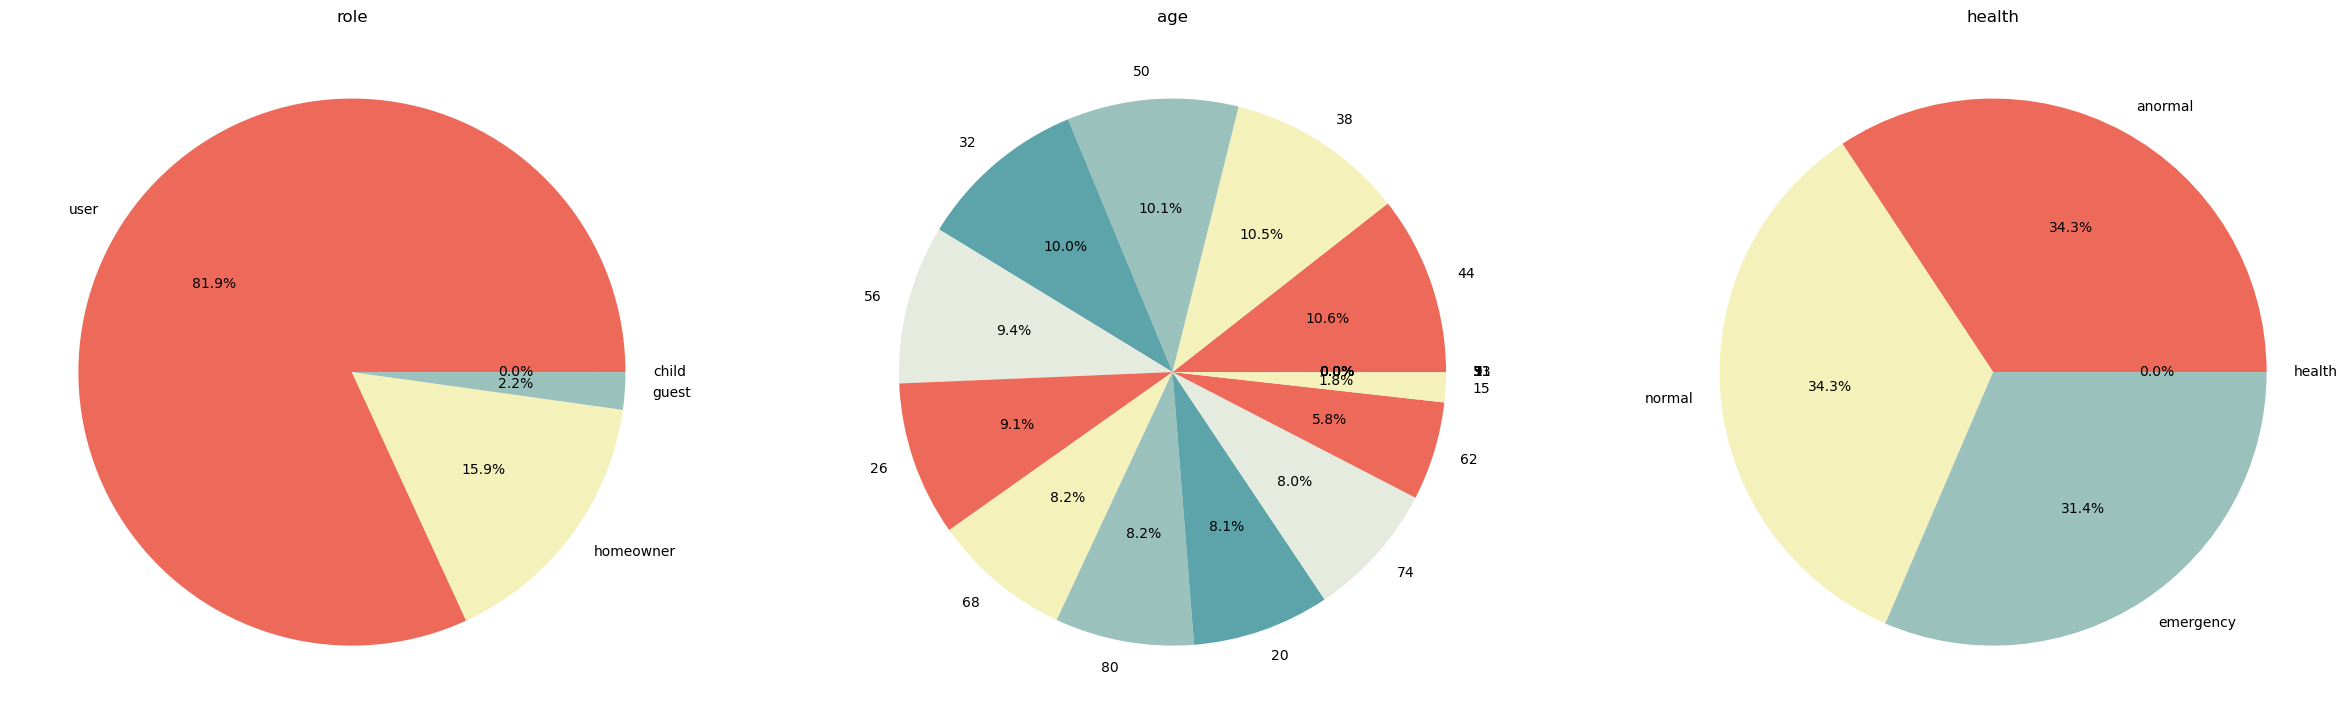

In [12]:
acc_log_to_analyze = normal_acc_log
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title(acc_log_to_analyze.columns[0])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[0]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[0]].value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%')

# AX-2
ax2.set_title(acc_log_to_analyze.columns[1])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[1]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[1]].value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

# AX-3
ax3.set_title(acc_log_to_analyze.columns[2])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[2]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[2]].value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')



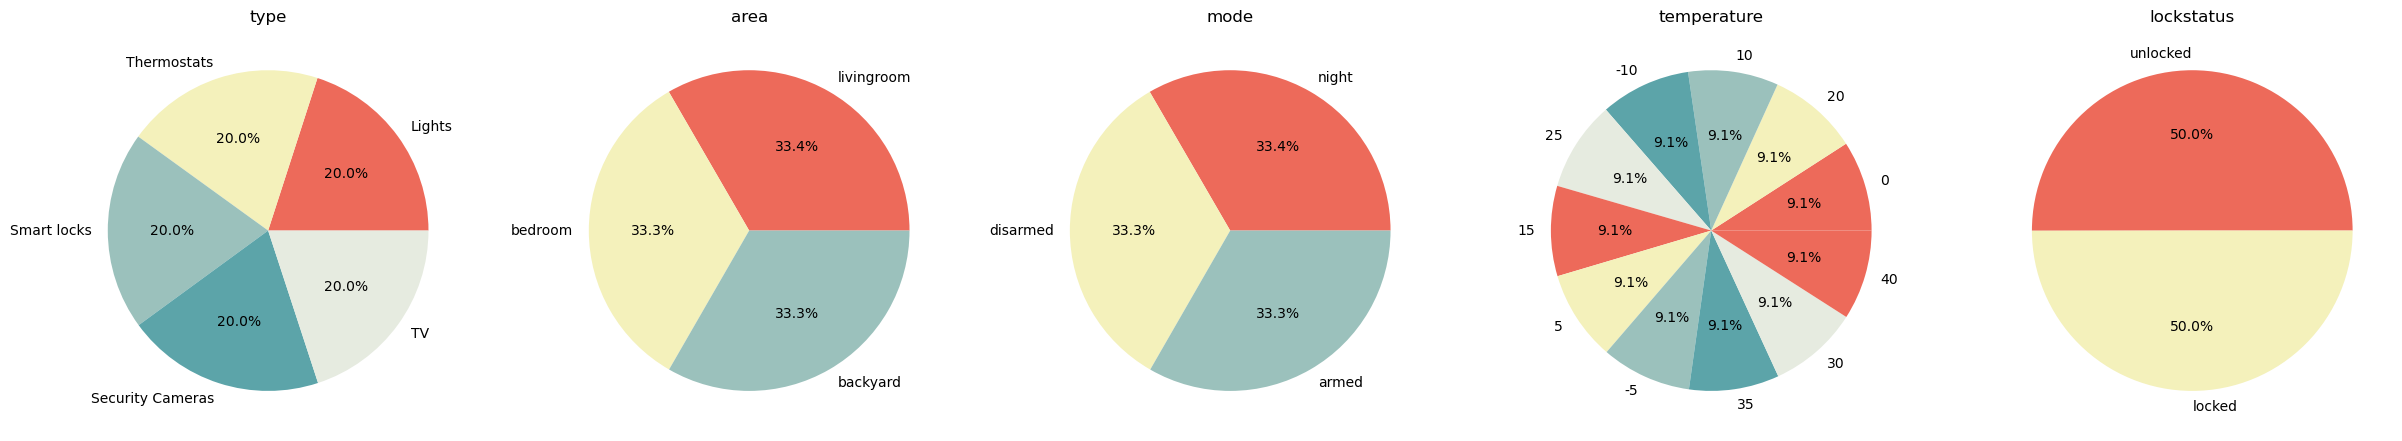

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title(acc_log_to_analyze.columns[4])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[4]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[4]].value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%')

# AX-2
ax2.set_title(acc_log_to_analyze.columns[5])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[5]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[5]].value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

# AX-3
ax3.set_title(acc_log_to_analyze.columns[6])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[6]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[6]].value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

# AX-4
ax4.set_title(acc_log_to_analyze.columns[7])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[7]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[7]].value_counts())
ax4.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

# AX-4
ax5.set_title(acc_log_to_analyze.columns[8])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[8]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[8]].value_counts())
ax5.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

plt.show()

([<matplotlib.patches.Wedge at 0x7f440034d5d0>,
 [Text(0.7770807821031351, 0.7785534394542099, 'access'),
  Text(-0.7794812445007231, 0.776150107563997, 'arm'),
  Text(-0.7760030384458154, -0.7796276574896908, 'emergency'),
  Text(0.7787000280388058, -0.7769338880061568, 'control')],
 [Text(0.4238622447835282, 0.424665512429569, '25.0%'),
  Text(-0.4251715879094853, 0.42335460412581655, '25.0%'),
  Text(-0.4232743846068084, -0.4252514495398313, '25.0%'),
  Text(0.4247454698393486, -0.42378212073063093, '25.0%')])

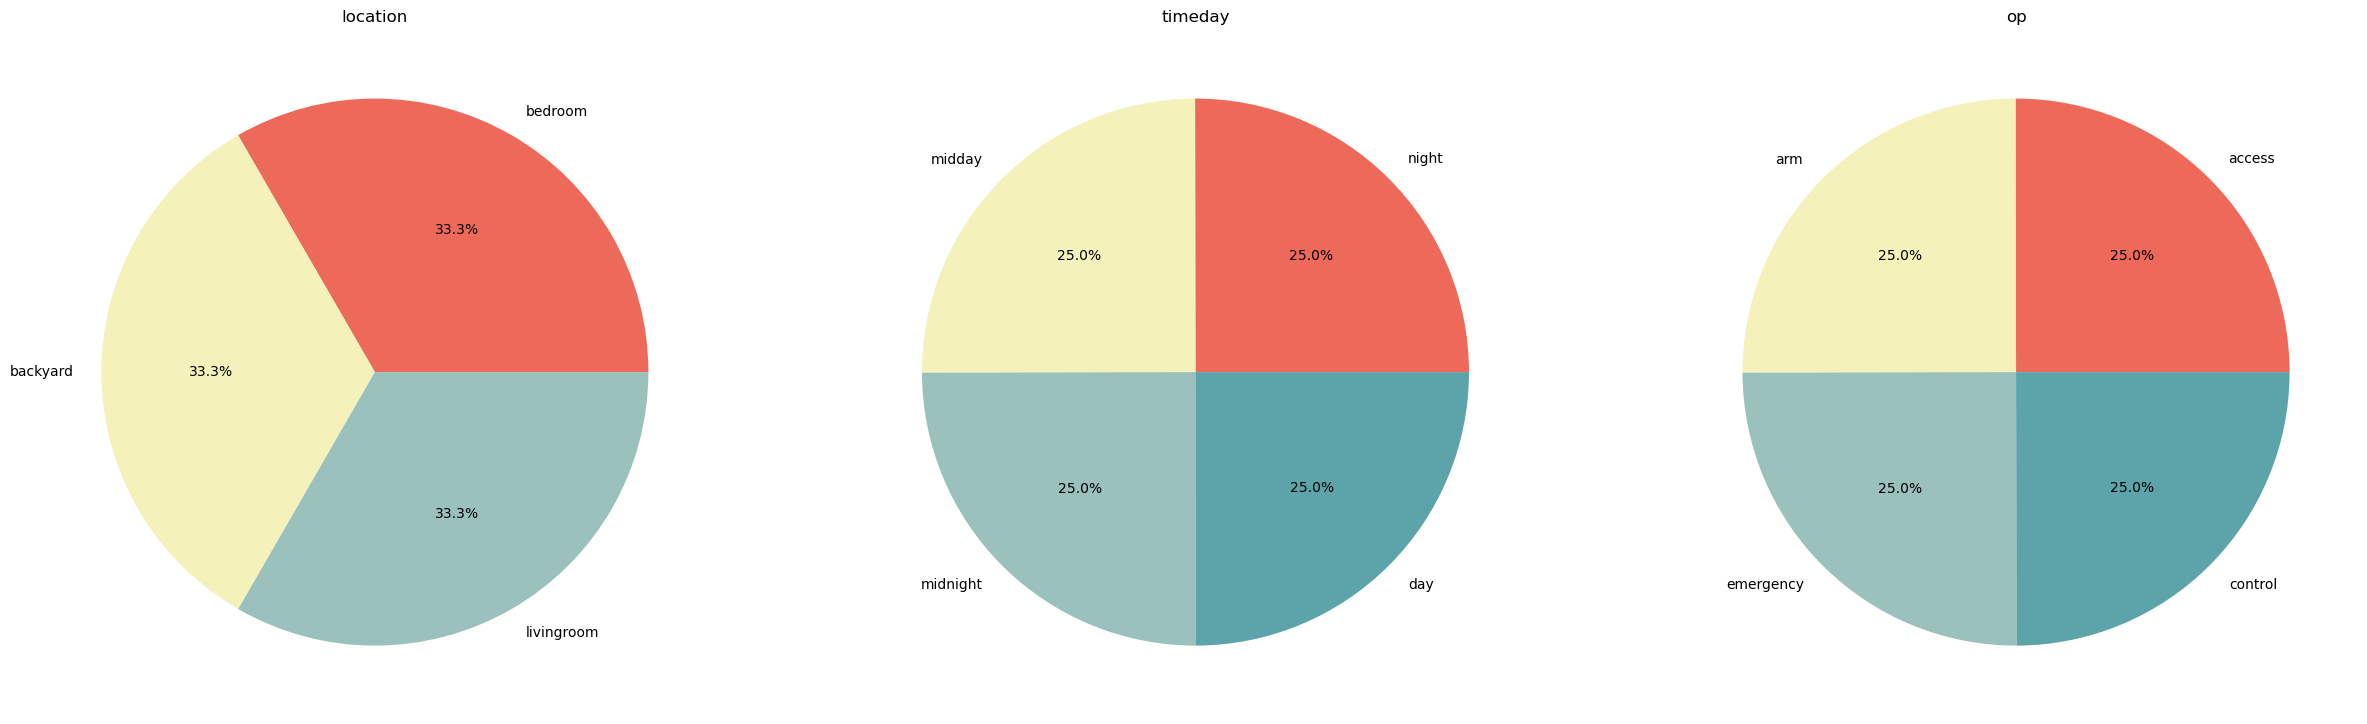

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,50))
color_palette = ['#ED6A5A', '#F4F1BB', '#9BC1BC', '#5CA4A9', '#E6EBE0']
#'#EFC164', '#F3835D', '#F35955', '#286275', '#00434C']

# AX-1
ax1.set_title(acc_log_to_analyze.columns[10])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[10]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[10]].value_counts())
ax1.pie(data_, labels=labels_, colors=color_palette[:len(labels_)], 
        autopct='%1.1f%%')

# AX-2
ax2.set_title(acc_log_to_analyze.columns[11])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[11]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[11]].value_counts())
ax2.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')

# AX-3
ax3.set_title(acc_log_to_analyze.columns[12])
labels_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[12]].value_counts().index)
data_ = list(acc_log_to_analyze[acc_log_to_analyze.columns[12]].value_counts())
ax3.pie(data_, labels=labels_, colors=color_palette[:len(labels_)],
        autopct='%1.1f%%')